In [ ]:
# This code fits our stripped star candidates to the composite grid of models
# It uses the chi squared statistic to find the best fit model and the log likelihood to find the best fit model
# It also finds the confidence interval for the stripped star mass and the MS companion mass
# It saves the results to a csv file
# Primary Author: Bethany Ludwig 
# Secondary Author: Maria Drout
# Last update: 2025-02-20
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import colorcet as cc
import matplotlib.colors as colors
from scipy.stats import chi2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import interpolate
import os 
pd.options.mode.chained_assignment = None

data_dir = os.getenv("DATADIR")
plt.style.use(data_dir+'bl.mplstyle')

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


# The fit results for stripped stars candidates
candidates = pd.read_csv(data_dir+'0_SUMS_Catalogs/CandidateCatalog/4_stripped_star_candidates_fit.csv')
l_candidates = candidates[candidates.galaxy == 'lmc'] 
s_candidates = candidates[candidates.galaxy == 'smc'] 

# Use the original composite grid for plotting 
l_comp = pd.read_csv(data_dir+'0_SUMS_Catalogs/CompositeGrid/lmc_composite_photometry.csv')
s_comp = pd.read_csv(data_dir+'0_SUMS_Catalogs/CompositeGrid/smc_composite_photometry.csv')

# ZAMS models for plotting
l_zams = pd.read_csv(data_dir+'1_Models/ZAMS/lmc_zams_apparent.csv')
s_zams = pd.read_csv(data_dir+'1_Models/ZAMS/smc_zams_apparent.csv')

# Create columns to later constrain by
for gal_df in [l_candidates,s_candidates]:
    # Add width column for stripped stars
    gal_df['fit_strip_width'] = np.abs(gal_df['fit_M_strip_max'] - gal_df['fit_M_strip_min'])
    # Add width column for MS stars
    gal_df['fit_MS_width'] = np.abs(gal_df['fit_M_MS_max'] - gal_df['fit_M_MS_min'])
    # Determine a fractional error on stripped and ms stars individually
    gal_df['frac_err_strip'] = gal_df['fit_strip_width']/gal_df['fit_M_strip']
    gal_df['frac_err_MS'] = gal_df['fit_MS_width']/gal_df['fit_M_MS']


def cut_stars(gal_df,frac_err_limit):
    # Brightness cutoff 
    size = gal_df.shape[0]
    gal_df = gal_df.loc[gal_df['uvm2'] > 16.].reset_index(drop=True)
    print('brightness cut',gal_df.shape[0] - size)

    # Remove if below 5sigma
    size = gal_df.shape[0]
    q_sigma = 0.999999 # 5sigma confidence interval
    chi2_limit = np.array([chi2.ppf(q_sigma, dof) for dof in gal_df.fit_dof])
    gal_df = gal_df.loc[gal_df.fit_chi_sq < chi2_limit].reset_index(drop=True)
    print('chi2 cut',gal_df.shape[0] - size)

    # Cut out stars with fractional errors greater than frac_err_limit
    # extra condition if MS/or stripped star is isolated
    size = gal_df.shape[0]
    gal_df = gal_df.loc[(gal_df['frac_err_MS'] < frac_err_limit) | ((gal_df['fit_M_MS_min'] == 0.) & (gal_df['fit_MS_width'] < 3.))].reset_index(drop=True)
    gal_df = gal_df.loc[(gal_df['frac_err_strip'] < frac_err_limit)].reset_index(drop=True)
    print('frac err cut',gal_df.shape[0] - size)
    
    return gal_df

frac_err_limit = 1
print('Init Total: ',len(candidates))
print(' ')
print('Init Size LMC: ',len(l_candidates))
l_candidates = cut_stars(l_candidates,frac_err_limit)
print('Size LMC: ',len(l_candidates))
print(' ')
print('Init Size SMC: ',len(s_candidates))
s_candidates = cut_stars(s_candidates,frac_err_limit)
print('Size SMC: ',len(s_candidates))
print(' ')
print('Final Total: ',len(l_candidates) + len(s_candidates))


# Get the Grid 
def DistanceFromZams(df,zams,blue_band,red_band):

    data_x = df[blue_band] - df[red_band]
    data_y = df[blue_band]
    zams_blue = zams[blue_band.lower()]
    zams_red = zams[red_band.lower()]
    curve_x = np.array(zams_blue) - np.array(zams_red)
    curve_y = np.array(zams_blue)
    f = interpolate.interp1d(curve_x, curve_y)
    xnew = np.linspace(np.min(curve_x),np.max(curve_x),10000)
    ynew = f(xnew)

    # Where is data_y closest to ynew?
    distances = []
    for ind, row in df.iterrows():
        x = row[blue_band] - row[red_band]
        y = row[blue_band]
        i_ymin = np.argmin(np.abs(ynew - y))
        i_x = xnew[i_ymin]
        d = x - i_x
        distances.append(d)

    return np.array(distances)

def get_grid(composite_df,zams,blue_band,red_band):
    composite_df = composite_df.copy()
    composite_df['distance_from_zams'] = DistanceFromZams(composite_df,zams,blue_band,red_band)
    composite_df.loc[composite_df.distance_from_zams > 0.0,'blue'] = 'no'
    composite_df.loc[composite_df.distance_from_zams < 0.0,'blue'] = 'yes'
    X = np.sort(composite_df.M_strip.unique())
    Y = np.sort(composite_df.M_MS.unique())
    Y_not_calculated = np.arange(0.2,1.0,0.2)
    Y = np.sort(np.append(Y,Y_not_calculated))
    X,Y = np.meshgrid(X,Y)
    shape = X.shape
    X_flat,Y_flat = X.flatten(),Y.flatten()
    Z = []
    blues = []
    for x,y in zip(X_flat, Y_flat):
        blue_condition = composite_df[(composite_df.M_strip == x) & (composite_df.M_MS == y)].blue.values
        if len(blue_condition) == 1:
            if blue_condition == 'yes' or y == 0.0:
                Z.append(1)
            elif blue_condition == 'no':
                Z.append(0)
            else:
                Z.append(np.nan)
        else:
            Z.append(2)
    Z = np.array(Z).reshape(shape)
    return X,Y,Z

l_grid = get_grid(l_comp,l_zams,'UVM2','V')
s_grid = get_grid(s_comp,s_zams,'UVM2','V')

Init Total:  820
 
Init Size LMC:  522
brightness cut -137
chi2 cut -122
frac err cut -73
Size LMC:  190
 
Init Size SMC:  298
brightness cut -55
chi2 cut -61
frac err cut -76
Size SMC:  106
 
Final Total:  296


Candidates plotted: 190
Mstrip -> min:0.62 max:7.14 median:1.05 mean:1.49
MMS -> min:0.0 max:5.8 median:2.0 mean:2.15
Candidates plotted: 106
Mstrip -> min:0.67 max:3.36 median:1.15 mean:1.38
MMS -> min:0.0 max:4.2 median:2.6 mean:2.46


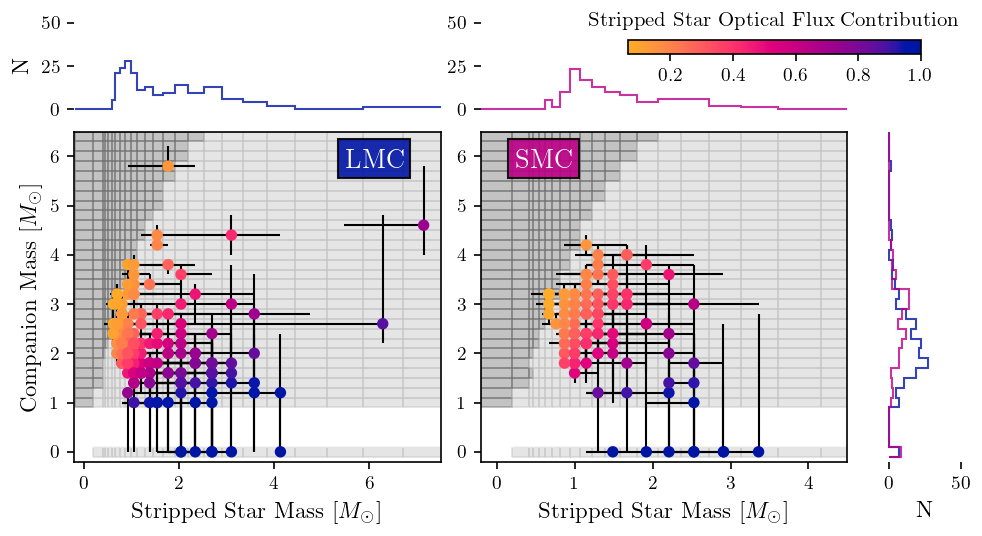

In [110]:
fig_w = 7.12663097223 +0.5
fig_h = 3.8
cmap = cc.cm.bmy_r
scatter_colors = truncate_colormap(cmap, 0.2,0.9)
marker_size = 20
lmc_color = '#0015A5'
smc_color = '#BC0087'

f = plt.figure(constrained_layout=False, figsize=(fig_w, fig_h),dpi=150)

# Use gridspec to set the size of the subplots for the first two 
size_low = 0.05
size_high = 0.2
size_mid = 1 - size_low - size_high
width = 1
# Init gridspec 
gs = f.add_gridspec(2, 3,  height_ratios=(size_high, size_mid),width_ratios=(width,width,size_high))
gs.update(wspace=0.15, hspace=0.1)

# Top Histogram 
lmc_hist = f.add_subplot(gs[0,0])
smc_hist = f.add_subplot(gs[0,1])

# Side Histogram 
both_hist = f.add_subplot(gs[1,2])

# Main plot 
l_ax_t = f.add_subplot(gs[1,0])
r_ax_t = f.add_subplot(gs[1,1])


top = [l_ax_t,r_ax_t]
hist = [lmc_hist,smc_hist,both_hist]


# Set ticks
[ax.set_xticks([]) for ax in hist[0:2]]
both_hist.set_yticks([]) 
[ax.tick_params(axis='both', which='major') for ax in hist]


# Remove the spines from the histograms
[ax.spines[:].set_visible(False) for ax in hist]

# Set labels
top[0].set_ylabel(r'Companion Mass [$M_{\odot}$]')


cands = []
colorbars = []
for galaxy in ['lmc','smc']:
    if galaxy == 'lmc':
        ax = l_ax_t
        ax_hist = lmc_hist
        color_hist = lmc_color
        candidates = l_candidates
        X,Y,Z = l_grid
        xdim = [-0.2,7.5]
        ydim = [-0.2,6.5]
  
    else:
        ax = r_ax_t
        ax_hist = smc_hist
        color_hist = smc_color
        candidates = s_candidates
        X,Y,Z = s_grid
        xdim = [-0.2,4.5]
        ydim = [-0.2,6.5]

    # uncomment to see everything
    #xdim = [-0.2,12]
    #ydim = [-0.2,12]

    # Scattter plot 
    print(f'Candidates plotted: {len(candidates)}')
    print(f'Mstrip -> min:{candidates.fit_M_strip.min()} max:{candidates.fit_M_strip.max()} median:{candidates.fit_M_strip.median()} mean:{candidates.fit_M_strip.mean():.2f}')
    print(f'MMS -> min:{candidates.fit_M_MS.min()} max:{candidates.fit_M_MS.max()} median:{candidates.fit_M_MS.median()} mean:{candidates.fit_M_MS.mean():.2f}')
    cax = ax.scatter(candidates.fit_M_strip,candidates.fit_M_MS,c=candidates.fit_V_flux_frac,cmap=scatter_colors,s=marker_size,alpha=1,zorder=10)
    # Horrizontal Errorbars: X axis, First value is Y position
    ax.hlines(candidates.fit_M_MS, candidates.fit_M_strip_min, candidates.fit_M_strip_max,color='k',zorder=9)
    # Vertical Errorbars: Y axis, First value is X position
    ax.vlines(candidates.fit_M_strip, candidates.fit_M_MS_min, candidates.fit_M_MS_max,color='k',zorder=9)
    colorbars.append(cax)
    ax.set_xlim(xdim)
    ax.set_ylim(ydim)
    ax.set_xlabel(r'Stripped Star Mass [$M_{\odot}$]')

    # Grid
    grid_alpha = 0.4
    cMap = colors.ListedColormap(['dimgrey','silver','black'])
    cMap = colors.ListedColormap(['silver','whitesmoke','dimgrey'])
    cMap = colors.ListedColormap(['dimgrey','silver','white'])

    pcol = ax.pcolormesh(X,Y,Z,cmap=cMap,linewidth=0.8,alpha=grid_alpha,zorder=-1) # rasterized=True,
    pcol.set_edgecolor('face')

    # Histograms 
    # Get bins from pcolormesh 
    xbins = np.array(pcol.get_coordinates()[0,:,0])
    ybins = np.array(pcol.get_coordinates()[:,0,1])

    # Make histogram for the top 
    hist, bins, _ = ax_hist.hist(candidates.fit_M_strip,bins=xbins,color=color_hist,alpha=0.8,histtype='step',lw=1,range=(xdim[0],xdim[1]))
    ax_hist.set_xlim(xdim)
    ax_hist.set_ylim(-1,50)
    hist_yticks = [0,25,50]
    hist_yticks = [0,25,50]
    ax_hist.set_yticks(hist_yticks)
    ax_hist.set_yticklabels([str(i) for i in hist_yticks])
    
    # Make histogram for the side
    hist, bins, _ = both_hist.hist(candidates.fit_M_MS,bins=ybins,color=color_hist,alpha=0.8,histtype='step',orientation='horizontal',lw=1,range=(ydim[0],ydim[1]))
    both_hist.set_ylim(ydim)
    both_hist.set_xlim(-1,50)
    xticks = [0,50]
    both_hist.set_xticks(xticks)
    both_hist.set_xticklabels([str(i) for i in xticks])
    both_hist.set_xlabel('N')


# Galaxy labels 
gal_text_color = 'white'
w= 0.75 # under 16 


# Rectangles for the galaxy label
bw = .2
box_x_lmc = 5.5
box_x_smc = 0.25
l_ax_t.add_patch(plt.Rectangle((box_x_lmc-bw+0.05,ydim[1]-w-bw), 1.5, 0.8,ec='k',fc=lmc_color,alpha=0.9))
r_ax_t.add_patch(plt.Rectangle((box_x_smc-bw+0.1,ydim[1]-w-bw),0.9, 0.8,ec='k',fc=smc_color,alpha=0.9))
                        
# Text for the galaxy label
fs=13
l_ax_t.text(box_x_lmc,ydim[1]-w+0.01,'LMC',color=gal_text_color,weight='demi',fontsize=fs)
r_ax_t.text(box_x_smc,ydim[1]-w+0.01,'SMC',color=gal_text_color,weight='demi',fontsize=fs)

# Add colorbar, make sure to specify tick locations to match desired ticklabels
ticks = list(np.arange(0,1.2,0.2))
tick_labels = [str(np.round(tick,1)) for tick in ticks]

axins = inset_axes(smc_hist, # here using axis of the lowest plot
               width="80%",  # width = X% of parent_bbox width
               height="15%",  
               bbox_to_anchor=(.2, -0.2, 1., 1.),
               bbox_transform=smc_hist.transAxes,
               borderpad=0,
               )
lmc_hist.set_ylabel('N')
cbar = f.colorbar(colorbars[0], cax=axins,ticks=ticks,orientation='horizontal')
cbar.ax.set_xticklabels(tick_labels) 
cbar.set_label('Stripped Star Optical Flux Contribution',labelpad=-35,fontsize=10)

# Having a hard time vectorizing because the color in the colorbar doesnt appear. 

plt.savefig('SED_fitting.png',dpi=1000)

In [90]:
267+149


416

In [77]:
4*10**-1

0.4